In [39]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

from pandas.io import wb
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os, time
import itertools

from wb_api_wraper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# WB data

In [40]:
#population from WB
pop      =get_wb_mrv('SP.POP.TOTL'      ,"pop").squeeze()#population

In [41]:
#country dictionary
iso_country = pd.read_csv("iso3_to_wb_name.csv", index_col = "iso3", squeeze=True)

###data on exposure per bassin per country per hydro return period

In [42]:
#Reads and adapts chaging raw data to current code

translator ={'iso_a3':"country_iso", "fpu_id":"fpu_id", 'lssum':'fpu_population', 'py5sum':"5", 'py10sum':"10",
        'py25sum':"25",  'py50sum':"50",  'py100sum':"100", 'py250sum':"250",  'py500sum':"500",  'py1000sum':"1000",
        'admin':'name'}
#translates random column names to what i want to use

ebp=pd.read_csv("basins_0702_adrien.csv")
ebp.columns=ebp.columns.str.lower()
ebp =ebp.rename(columns=translator)[sorted(list(translator.values()))];
ebp.head()


,10,100,1000,25,250,5,50,500,country_iso,fpu_id,fpu_population,name
0,0,0,0,0,0,0,0,0,AFG,20,472,Afghanistan
1,73400,105534,117383,102266,105828,34094,104100,116724,AFG,172,2791282,Afghanistan
2,461759,599214,680372,539858,635334,322025,565776,651817,AFG,188,7392882,Afghanistan
3,74,1364,4854,1243,4447,47,1364,4854,AFG,205,135807,Afghanistan
4,1798,2275,2905,1907,2499,1659,2256,2754,AFG,206,21637,Afghanistan


In [43]:
name_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)

In [44]:
ebp["country"] = ebp.name.replace("any_name_to_wb_name.csv")

In [45]:
#wb country names
#ebp["country"]= ebp["country_iso"].replace(iso_country)

In [46]:
#return period and associated bins
col_names = {'5':5, '10':10, '25':25, '50':50, '100':100, '250':250, '500':500, '1000':1000}
p = sorted(list(col_names.values()))  #"probas" of each return period
p

[5, 10, 25, 50, 100, 250, 500, 1000]

In [47]:
#reshaping
expo_bassin = ebp.set_index(["country","fpu_id"]).drop(["country_iso","name"],axis=1).sortlevel().rename(columns=col_names)

#separates exposure and total population
pop_bassin_country = expo_bassin["fpu_population"]
expo_bassin = expo_bassin[p]

#Assumes nobody exposed under 5 years
expo_bassin[0]=0
expo_bassin.sort_index(axis=1,inplace=True)

#number of people exposed in each country,bassin
expo_bassin.head()


0       5       10      25      50      100     250   \
country     fpu_id                                                         
Afghanistan 20         0       0       0       0       0       0       0   
            172        0   34094   73400  102266  104100  105534  105828   
            188        0  322025  461759  539858  565776  599214  635334   
            205        0      47      74    1243    1364    1364    4447   
            206        0    1659    1798    1907    2256    2275    2499   

                      500     1000  
country     fpu_id                  
Afghanistan 20           0       0  
            172     116724  117383  
            188     651817  680372  
            205       4854    4854  
            206       2754    2905

Countries with missmatch between WB pop and bassin pop country
Aruba                       0.000015
Cyprus                      0.588743
Greenland                   0.303881
Solomon Islands             0.556066
Somalia                     0.694297
Turks and Caicos Islands    0.568265
United Arab Emirates        0.500055
Vanuatu                     0.618116
dtype: float64


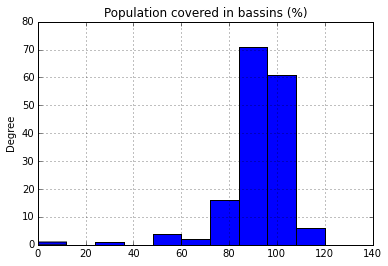

In [48]:
#Country population sanity check
check = (pop_bassin_country.sum(level="country")/pop)
(100*check).plot(kind="hist",title="Population covered in bassins (%)")
print("Countries with missmatch between WB pop and bassin pop",check[check<.7])
check.to_csv("pop_covered_bassins.csv")
del check

In [49]:
#Bassin population sanity check (same bassin should be different accross countries)
expo_bassin.reset_index().set_index("fpu_id").sort_index().head()

,country,0,5,10,25,50,100,250,500,1000
fpu_id,,,,,,,,,,
2,Greenland,0,0,0,0,0,0,0,0,0
3,Russia,0,362,442,546,578,612,660,679,689
4,Russia,0,3318,4469,5036,5462,5705,6047,6217,6458
5,United States of America,0,1364,1603,1674,1793,1804,1848,1918,1930
5,Canada,0,2520,2556,3522,3862,4193,4193,4194,4856


In [50]:
#fraction of people exposed in the bassin for each return period (NOT USED)
exp_bass_rel=expo_bassin.div(pop_bassin_country,axis=0)
expo_bassin.columns.name = "event"
exp_bass_rel.head()
del exp_bass_rel

In [51]:
#reshaping
exposures = expo_bassin.stack().reset_index().rename(columns={0:"nba"})
exposures.ix[20:24]

,country,fpu_id,event,nba
20,Afghanistan,188,10,461759
21,Afghanistan,188,25,539858
22,Afghanistan,188,50,565776
23,Afghanistan,188,100,599214
24,Afghanistan,188,250,635334


###Simulates events (mind memory usage from here)

In [52]:
n=int(7e3)

#random dataframe X~1/Uniform([0,1])
alea = pd.DataFrame(columns=expo_bassin.index,index=range(0,n))
alea = pd.DataFrame( np.power(np.random.random(alea.shape),-1), columns=alea.columns,index=alea.index)
alea.index.name="sce"
alea.head()

country Afghanistan                                                      \
fpu_id          20        172       188        205       206        471   
sce                                                                       
0          4.209815  5.718499  1.824087   2.764006  5.313652   1.489750   
1          1.013205  1.046485  1.015266   3.857962  1.347923   1.258237   
2          1.090851  2.386628  1.254644  40.039021  2.980645  20.911481   
3          4.579079  6.054144  1.609542   1.857419  2.294507   1.580714   
4          1.162061  2.404251  5.732499  15.497109  9.659252   1.018978   

country           Akrotiri Sovereign Base Area      Aland    Albania  \
fpu_id        491                          171        95         15    
sce                                                                    
0        2.117720                     2.353280   1.453977   3.785791   
1        1.348861                     1.547115   1.848769   3.842494   
2        1.681152                     2.490145  28.003410   2.843228   
3        2.253917                     1.080483   1.313015   4.584885   
4        8.035220                     1.923205   3.730135  98.906702   

country    ...       Zambia                                    Zimbabwe  \
fpu_id     ...          361       531        539         541        33    
sce        ...                                                            
0          ...     1.059351  1.296687   3.123938    1.236118   2.628700   
1          ...     1.055220  1.663566   1.735559    1.868056   1.129856   
2          ...     1.035725  1.412877   3.886113    1.527155  10.778093   
3          ...     1.902268  1.627860   1.329553  441.003888  11.697255   
4          ...     3.544302  4.548785  11.948113   22.050102   4.995182   

country                                                      
fpu_id        38        41         391        392       399  
sce                                                          
0        1.029524  1.706364   2.418151  11.986821  1.177316  
1        2.283859  3.020927   1.504365   1.369823  5.823641  
2        2.410746  1.931642   6.829203   1.332138  1.576213  
3        2.123731  1.562920   1.508355   1.400854  1.669622  
4        2.230062  1.913108  27.860030   2.061512  1.006199  

[5 rows x 1211 columns]

In [53]:
#ugly reshaping
alea = alea.unstack().reset_index().rename(columns={0:"rand"})
alea.ix[20:24]

,country,fpu_id,sce,rand
20,Afghanistan,20,20,1.807770
21,Afghanistan,20,21,2.241965
22,Afghanistan,20,22,2.302994
23,Afghanistan,20,23,1.403484
24,Afghanistan,20,24,2.201095


In [54]:
#Disretizes events to closest documented event
bins = p.copy()
bins.insert(0,0)
bins.append(np.inf)
print(bins)

alea["event"] = pd.cut(alea.rand,bins,labels = bins[:-1])

alea.head(10)

[0, 5, 10, 25, 50, 100, 250, 500, 1000, inf]


,country,fpu_id,sce,rand,event
0,Afghanistan,20,0,4.209815,0
1,Afghanistan,20,1,1.013205,0
2,Afghanistan,20,2,1.090851,0
3,Afghanistan,20,3,4.579079,0
4,Afghanistan,20,4,1.162061,0
5,Afghanistan,20,5,5.689872,5
6,Afghanistan,20,6,1.728523,0
7,Afghanistan,20,7,1.325600,0
8,Afghanistan,20,8,254.145766,250
9,Afghanistan,20,9,1.449216,0


In [55]:
#sanity check: are return periods numerically matched? with n=1e3 error is  about 2% for rp=1000. 
#error is .1% with n=1e4
#at country scale the error is still less than .1%

#theory
q = [0]+[1-1/x for x in p]+[1]
q=np.diff(q)
print("theory",q)

#practice
counts = alea.ix[alea.country=="France"].event.value_counts()
print("\npractice\n",counts/counts.sum())

#relative error
print("\nerror\n",100*np.abs(counts/counts.sum()-q)/q)

theory [ 0.8    0.1    0.06   0.02   0.01   0.006  0.002  0.001  0.001]

practice
 0       0.800385
5       0.100319
10      0.059516
25      0.020363
50      0.009945
100     0.005549
250     0.002055
1000    0.001011
500     0.000857
dtype: float64

error
 0        0.048077
5        0.318681
10       0.805861
25       1.813187
50       0.549451
100      7.509158
250      2.747253
1000     1.098901
500     14.285714
dtype: float64


##Socio-economice exposure

In [56]:
#exposure per country, bassin, event (merges events and exposure for each event ) (WAY TOO LONG)
m = pd.merge(alea,exposures,on=["country","fpu_id","event"],how="left").set_index(["country","sce","fpu_id"]).sortlevel()
print("should read zero:",alea.shape[0]-m.shape[0])
#m.event.unique()

should read zero: 0


In [57]:
#summing afected people accross bassins and reshaping
nba=m["nba"].sum(level=["country","sce"]).unstack("country") #number of people exposed by sceneario 
nba.head()

country,Afghanistan,Akrotiri Sovereign Base Area,Aland,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
sce,,,,,,,,,,,,,,,,,,,,,
0,35753,0,0,0,22,0,46311,0,253522,48182,...,17321,38393,0,0,25,148380,0,0,140875,54266
1,0,0,0,0,488,0,59031,0,439805,0,...,0,0,0,0,323688,710435,0,0,5213,12488
2,604530,0,0,0,100258,12413,197148,0,5799,0,...,0,0,0,0,1844,3018331,0,0,128054,1848
3,34094,0,0,0,0,1829,1739,0,81176,48182,...,21770,52321,0,0,1844,4774483,0,0,75368,111
4,1573627,0,0,0,1280657,0,0,0,211839,0,...,0,0,0,0,1844,5978264,0,0,71943,1737


###Using two different sources for population here: not great

In [58]:
#fraction of total population 
fa=nba.div(pop).dropna(how="all",axis=1)
del nba
fa.head()

country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
sce,,,,,,,,,,,,,,,,,,,,,
0,0.001143,0,5.509787e-07,0.000000,0.002092,0,0.006065,0.016147,0,0.000666,...,0.002418,0.018105,0,0.028948,0.005067,0.001249,0,0.001635,0.009379,0.003717
1,0.000000,0,1.222171e-05,0.000000,0.002667,0,0.010521,0.000000,0,0.000012,...,0.000000,0.005007,0,0.000000,0.000000,0.000000,0,0.007830,0.000347,0.000855
2,0.019326,0,2.510910e-03,0.154866,0.008906,0,0.000139,0.000000,0,0.001943,...,0.000000,0.009230,0,0.000514,0.000000,0.000000,0,0.033267,0.008525,0.000127
3,0.001090,0,0.000000e+00,0.022819,0.000079,0,0.001942,0.016147,0,0.001943,...,0.000000,0.024650,0,0.019049,0.006368,0.001702,0,0.052623,0.005018,0.000008
4,0.050307,0,3.207340e-02,0.000000,0.000000,0,0.005068,0.000000,0,0.011608,...,0.000000,0.005604,0,0.028948,0.000000,0.000000,0,0.065891,0.004789,0.000119


In [59]:
#using quantiles to compute return periods
quant = [1-1/x for x in p]
print("Quantiles:" ,quant)
result = fa.quantile(quant).transpose().dropna()
result.columns = p
result

Quantiles: [0.8, 0.9, 0.96, 0.98, 0.99, 0.996, 0.998, 0.999]


,5,10,25,50,100,250,500,1000
country,,,,,,,,
Afghanistan,0.039957,0.047500,0.058818,0.064558,0.069613,0.076446,0.079196,0.082639
Albania,0.000000,0.045540,0.063216,0.074794,0.075965,0.077031,0.077672,0.079534
Algeria,0.005285,0.025215,0.028239,0.029208,0.030528,0.031877,0.032504,0.032835
Andorra,0.132047,0.132047,0.287076,0.287076,0.287076,0.309895,0.309895,0.309895
Angola,0.003141,0.009440,0.010457,0.011122,0.011559,0.012114,0.012513,0.012860
Antigua and Barbuda,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Argentina,0.023345,0.031550,0.039442,0.045897,0.050262,0.056462,0.059296,0.061508
Armenia,0.003229,0.016147,0.036124,0.036124,0.036177,0.037717,0.041634,0.047730
Aruba,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
result.to_csv("exposure_econ_return_period_FALSE.csv")

###Comparing with previous, erroneous, method

,0,5,10,25,50,100,250,500,1000
country,,,,,,,,,
Bhutan,,,,,,1.039436,1.037815,1.037815,
Croatia,,,,,1.104714,1.059221,,,


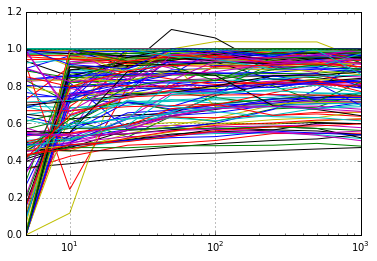

In [61]:
compare = (result/expo_bassin.sum(level="country").div(pop,axis=0))
compare.transpose().plot(legend=None, logx=True)
compare[compare>1].dropna(how="all").fillna(" ")